In [1]:
from pathlib import Path
import os, math, itertools, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import requests, shutil
from tqdm.auto import tqdm
from utils import * 

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})


## Hyper-parameters

In [88]:
SEED = 121
random.seed(SEED); np.random.seed(SEED)

n  = 800; xi = 350   

# Dataset root
DOMAINNET_ROOT = Path("./datasets/domainnet_data").resolve()
DOMAINNET_ROOT.mkdir(parents=True, exist_ok=True)

# Domains (choose any keys in DOMAINNET_URLS below)
DOMAIN_A = "real"
DOMAIN_B = "sketch"
IMG_SIZE = 128


## Downloading data

In [89]:

DOMAINNET_URLS = {
    "sketch":    "https://csr.bu.edu/ftp/visda/2019/multi-source/sketch.zip",
    "real":      "https://csr.bu.edu/ftp/visda/2019/multi-source/real.zip",
    "clipart":   "https://csr.bu.edu/ftp/visda/2019/multi-source/clipart.zip",
    "painting":  "https://csr.bu.edu/ftp/visda/2019/multi-source/painting.zip",
    "infograph": "https://csr.bu.edu/ftp/visda/2019/multi-source/infograph.zip",
    "quickdraw": "https://csr.bu.edu/ftp/visda/2019/multi-source/quickdraw.zip",
}

def ensure_domainnet(root, domains, urls=DOMAINNET_URLS, download=True, chunk=1<<20):
    root = Path(root); root.mkdir(parents=True, exist_ok=True)
    for dom in domains:
        dom_dir = root / dom
        if dom_dir.exists() and any(dom_dir.iterdir()):
            print(f"[ok] {dom_dir}"); continue
        if not download:
            raise FileNotFoundError(f"{dom_dir} missing and download=False")

        zip_path = root / f"{dom}.zip"
        url = urls[dom]
        print(f"[info] fetching {dom} from {url}")

        # download
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get("content-length", 0))
            with tqdm(total=total, unit="B", unit_scale=True, desc=f"Downloading {dom}") as pbar, open(zip_path, "wb") as f:
                for b in r.iter_content(chunk_size=chunk):
                    if b: f.write(b); pbar.update(len(b))

        # extract
        with ZipFile(zip_path) as zf:
            members = zf.infolist()
            with tqdm(total=len(members), desc=f"Extracting {dom}"):
                zf.extractall(root)
                tqdm.write("")  # keep bar clean

        zip_path.unlink(missing_ok=True)

        # if the expected folder isn't present, move a nested match into place (best-effort)
        if not dom_dir.exists():
            for p in root.rglob(dom):
                if p.is_dir() and p != dom_dir:
                    dom_dir.mkdir(exist_ok=True)
                    for item in p.iterdir():
                        shutil.move(str(item), str(dom_dir / item.name))
                    try: p.rmdir()
                    except: pass
                    break

        print(f"[ok] ready: {dom_dir}")

ensure_domainnet(DOMAINNET_ROOT, (DOMAIN_A, DOMAIN_B), download=True)


[ok] /Users/rohanhore/Documents/GitHub/CONCH/real_experiments/datasets/domainnet_data/real
[ok] /Users/rohanhore/Documents/GitHub/CONCH/real_experiments/datasets/domainnet_data/sketch


## Setting up domain shift data

In [90]:
A_root, B_root = DOMAINNET_ROOT/DOMAIN_A, DOMAINNET_ROOT/DOMAIN_B
A_classes = {p.name for p in A_root.iterdir() if p.is_dir()}
B_classes = {p.name for p in B_root.iterdir() if p.is_dir()}
common = sorted((A_classes & B_classes) - {"The_Mona_Lisa"})[:6]

def collect_jpg(root, dom, classes):
    out = {}
    for c in classes:
        files = list((root/dom/c).rglob("*.jpg"))
        if len(files) >= 10: out[c] = files  
    return out

paths_A = collect_jpg(DOMAINNET_ROOT, DOMAIN_A, common)
paths_B = collect_jpg(DOMAINNET_ROOT, DOMAIN_B, common)
usable  = sorted(set(paths_A) & set(paths_B))
paths_A = {c: paths_A[c] for c in usable}
paths_B = {c: paths_B[c] for c in usable}

In [91]:
common

['The_Eiffel_Tower',
 'The_Great_Wall_of_China',
 'aircraft_carrier',
 'airplane',
 'alarm_clock',
 'ambulance']

In [92]:
rng = np.random.default_rng(SEED)
def sample(paths_by_class, k):
    cls = list(paths_by_class); per = max(1, k // len(cls))
    chosen = []
    for c in cls:
        pool = paths_by_class[c][:]; rng.shuffle(pool)
        chosen += [(p, c) for p in pool[:min(per, len(pool))]]
    remain = k - len(chosen)
    if remain > 0:
        used = {p for p,_ in chosen}
        pool = [(p,c) for c in cls for p in paths_by_class[c] if p not in used]
        rng.shuffle(pool); chosen += pool[:remain]
    rng.shuffle(chosen); return chosen[:k]

pre, post = sample(paths_A, xi), sample(paths_B, n - xi)
stream = pre + post
stream_paths = [p for p,_ in stream]
stream_cls   = [c for _,c in stream]
stream_dom   = [DOMAIN_A]*xi + [DOMAIN_B]*(n - xi)

### Plot samples around $\xi$

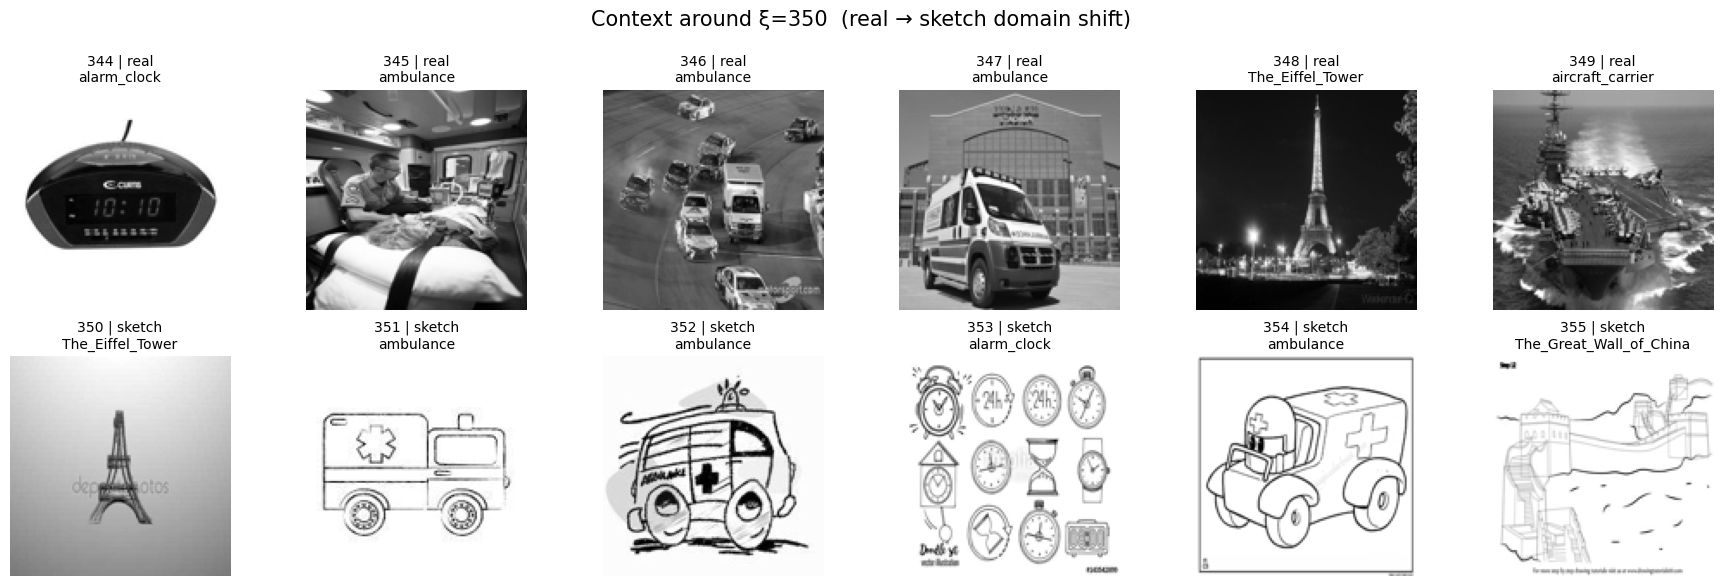

In [93]:
left, right = xi - 6, xi + 6
idx = range(left, right)
rows = 2
plt.figure(figsize=(6*3, rows*3))
for j, i in enumerate(idx, 1):
    ax = plt.subplot(rows, 6, j)
    img = Image.open(stream_paths[i]).convert("L").resize((IMG_SIZE, IMG_SIZE))
    ax.imshow(img, cmap="gray"); ax.axis("off")
    ax.set_title(f"{i} | {stream_dom[i]}\n{stream_cls[i]}", fontsize=10)

Path("../images").mkdir(parents=True, exist_ok=True)
plt.suptitle(f"Context around ξ={xi}  ({DOMAIN_A} → {DOMAIN_B} domain shift)", fontsize=15)
plt.savefig("../images/domain_shift_xi_panel.pdf", bbox_inches="tight", dpi=200)
plt.tight_layout(); plt.show()


## Train a classifier

### Set up dataloader: turn into grayscale images

In [94]:

_flatten = lambda d: [p for lst in d.values() for p in lst]
rng = np.random.default_rng(SEED)
A, B = _flatten(paths_A), _flatten(paths_B)
rng.shuffle(A); rng.shuffle(B)
cap = min(len(A), len(B), 2000)
A, B = A[:cap], B[:cap]

# label, shuffle, split 80/20
items = [(p, 0) for p in A] + [(p, 1) for p in B]
rng.shuffle(items)
split = int(0.8 * len(items))
train_items, val_items = items[:split], items[split:]

# minimal Dataset: strict 1-channel grayscale
class DomainBinaryDataset(Dataset):
    def __init__(self, items, img_size=IMG_SIZE, augment=False):
        base = ([transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomRotation(10)]
                if augment else
                [transforms.Resize(img_size), transforms.CenterCrop(img_size)])
        self.t = transforms.Compose(base + [transforms.Grayscale(1), transforms.ToTensor()])
        self.items, self.img_size = items, img_size
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        try: im = Image.open(p).convert("RGB")
        except: im = Image.new("RGB", (self.img_size, self.img_size), (200,200,200))
        return self.t(im), torch.tensor(y, dtype=torch.long)

train_dl = DataLoader(DomainBinaryDataset(train_items, IMG_SIZE, augment=True),
                      batch_size=64, shuffle=True, num_workers=0)
val_dl   = DataLoader(DomainBinaryDataset(val_items,   IMG_SIZE, augment=False),
                      batch_size=64, shuffle=False, num_workers=0)

xb, yb = next(iter(train_dl))
print("batch:", xb.shape, "| labels:", yb.unique().tolist())


batch: torch.Size([64, 1, 128, 128]) | labels: [0, 1]


### Set up a binary classifier

In [95]:

w = 32 
model = nn.Sequential(
    nn.Conv2d(1, w, 3, padding=1), nn.BatchNorm2d(w), nn.ReLU(True),
    nn.MaxPool2d(2),
    nn.Conv2d(w, 2*w, 3, padding=
              1), nn.BatchNorm2d(2*w), nn.ReLU(True),
    nn.MaxPool2d(2),
    nn.Conv2d(2*w, 4*w, 3, padding=1), nn.BatchNorm2d(4*w), nn.ReLU(True),
    nn.MaxPool2d(2),
    nn.Conv2d(4*w, 4*w, 3, padding=1), nn.BatchNorm2d(4*w), nn.ReLU(True),
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Dropout(0.2), nn.Linear(4*w, 2)
).to("cpu")

opt   = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)

print(f"params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.3f}M")


params: 0.241M


### Training the classifier

In [96]:
import torch.nn.functional as F
from tqdm.auto import tqdm

def run_epoch(dl, train=True):
    model.train(train)
    tot = correct = loss_sum = 0
    for xb, yb in dl:
        if train:
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward(); opt.step()
        else:
            with torch.no_grad():
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
        n = yb.size(0)
        loss_sum += loss.item() * n
        correct  += (logits.argmax(1) == yb).sum().item()
        tot      += n
    return loss_sum / tot, correct / tot

EPOCHS = 8
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    va_loss, va_acc = run_epoch(val_dl,   False)
    sched.step()
    print(f"[{ep}/{EPOCHS}] train {tr_loss:.3f}/{tr_acc:.3f} | val {va_loss:.3f}/{va_acc:.3f}")


[1/8] train 0.338/0.866 | val 0.612/0.753
[2/8] train 0.291/0.890 | val 0.496/0.780
[3/8] train 0.263/0.895 | val 0.498/0.760
[4/8] train 0.256/0.901 | val 0.442/0.855
[5/8] train 0.249/0.905 | val 0.281/0.879
[6/8] train 0.238/0.906 | val 0.245/0.892
[7/8] train 0.231/0.905 | val 0.243/0.894
[8/8] train 0.231/0.915 | val 0.241/0.907


## CONCH confidence set

#### Get logits

In [97]:
@torch.inference_mode()
def logits_for_paths(model, paths, img_size=IMG_SIZE, batch_size=64):
    t = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),             
    ])
    outs = []
    for i in range(0, len(paths), batch_size):
        batch = []
        for p in paths[i:i+batch_size]:
            im = Image.open(p).convert("L")  
            batch.append(t(im))
        xb = torch.stack(batch, 0)
        outs.append(model(xb).cpu())
    return torch.cat(outs, dim=0)


### Confidence set

In [98]:
logits = logits_for_paths(model, stream_paths)
p_B    = torch.softmax(logits, dim=1).numpy()[:, 1]

# CONCH p-values with classifier log-likelihood ratio as CPP score
pval = compute_p_values(logits.numpy(), class_before=0, class_after=1,
                              nperm=400, random_state=SEED)
conf_set = confidence_set(pval, 0.05)

print(f"ξ (true): {xi}")
print("Confidence set:", conf_set)

computing CONCH p-values:   0%|          | 0/799 [00:00<?, ?it/s]

ξ (true): 350
Confidence set: [350, 351]


### Visualization

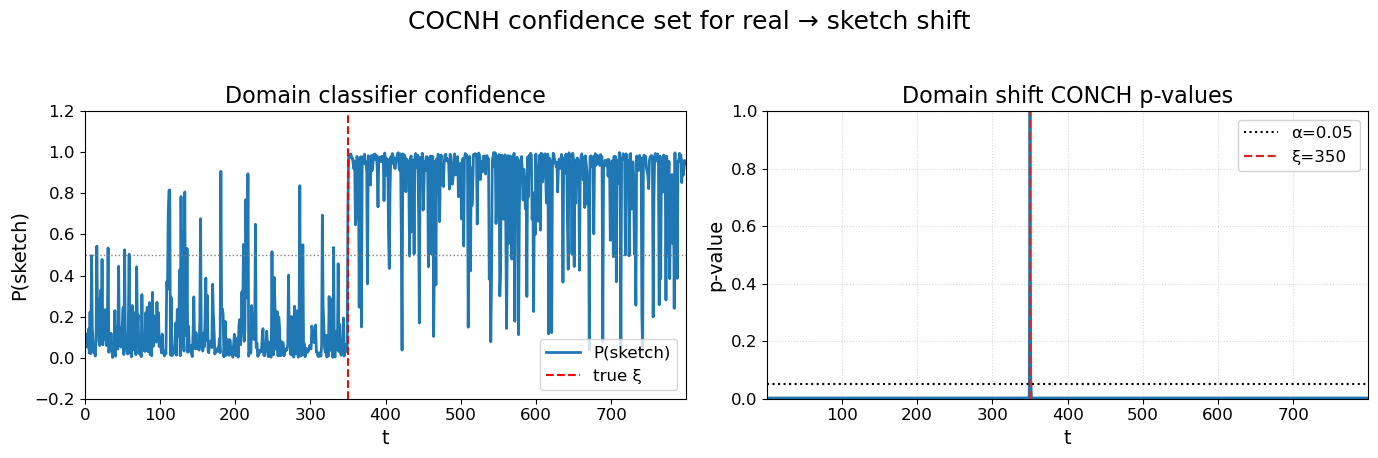

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Left: P(B)
ax = axes[0]
ax.plot(p_B, linewidth=2, label=f"P({DOMAIN_B})")
ax.axvline(x=xi, linestyle="--", linewidth=1.5, color="red", label="true ξ")
ax.axhline(0.5, color="gray", linestyle=":", linewidth=1)
ax.set(xlim=(0, len(p_B)-1), ylim=(-0.2, 1.2),
       xlabel="t", ylabel=f"P({DOMAIN_B})",
       title="Domain classifier confidence")
ax.legend(loc="lower right")

# Right: CONCH p-values
ax = axes[1]
tgrid = np.arange(1, len(pval) + 1)
ax.plot(tgrid, pval, linewidth=2)
ax.axhline(0.05, linestyle=":", color="black", linewidth=1.5, label="α=0.05")
ax.axvline(x=xi, linestyle="--", color="tab:red", linewidth=1.6, label=f"ξ={xi}")
ax.set(xlim=(1, len(pval)), ylim=(0, 1), xlabel="t", ylabel="p-value",
       title="Domain shift CONCH p-values")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(loc="upper right", framealpha=0.85)

fig.suptitle(f"COCNH confidence set for {DOMAIN_A} → {DOMAIN_B} shift", y=1.02)
Path("../images").mkdir(parents=True, exist_ok=True)
plt.savefig("../images/domain_shift_pvalues.pdf", bbox_inches="tight", dpi=200)
plt.tight_layout(); plt.show()
